In [1]:
import pandas
import random
import numpy as np
import math
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from model import *

img_shape = np.array([3, 32, 32])

Using TensorFlow backend.


### Collect data

place your data at the same floder with the github project

In [2]:
# input path of file
# return data extract from pickle
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def oneHot(y, class_num):
    one_hot_y = np.zeros((len(y), class_num))
    for i in range(len(y)):
        one_hot_y[i][y[i]] = 1
    return one_hot_y

### transform the raw data into image
below gives an example of how to extract the first image from the data


change index to get more

In [3]:
# input 2D data
# return BGR image
def flatToImg(flat, img_shape=img_shape):
    img = np.reshape(flat, img_shape)
    img = np.transpose(img, (1, 2, 0))
    return img

# read and show image
# flat = data[0]
# img = flatToImg(flat, img_shape)
# print(img.shape)
# plt.imshow(img)
# plt.show()

def transformData(data):
    new_data = np.zeros((data.shape[0], img_shape[1], img_shape[2], img_shape[0]), np.int32)
    for i in range(data.shape[0]):
        new_data[i] = flatToImg(data[i])
    return new_data

### extract secret from image and decode

In [4]:
# input: image
# return bits of image in one-dimention like
def getSecret(image):
    return np.unpackbits(np.array(image.flatten(), np.uint8))
  
image = np.array([[1, 2], [3, 4]])
getSecret(image)

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0], dtype=uint8)

In [5]:
# input: secret data s(binary), bool value
# return decimal data, if ture return a BGR image, else 2D value
def decode(s, imgShape = img_shape, toImg=False):
    # convert binary to decimals
    decimals = np.packbits(s);
    
    # devide secret into indival images
    img_len = img_shape[0] * img_shape[1] * img_shape[2]
    secret_img_num = int(len(decimals)/img_len)
    imgs = np.zeros([secret_img_num, img_len])
    for i in range(secret_img_num):
        imgs[i] = decimals[i*img_len:(i+1)*img_len]
    
    if not toImg:
        return imgs
    else:
        bgr_imgs = np.zeros([secret_img_num, img_shape[1], img_shape[2], img_shape[0]], np.int32)
        for i in range(secret_img_num):
            bgr_imgs[i] = flatToImg(imgs[i], img_shape)
        return bgr_imgs

# image = data[0]
# ss = getSecret(image)
# print(ss[:16])
# img = decode(ss, toImg = True)[0]
# print(img.shape)
# plt.imshow(img)
# plt.show()

## synthesizing malicious data

In [6]:
def GenData(img_idx, pix_idx, img_shape = img_shape):
#     randVal = random.randint(0,255)
#     image = np.zeros(img_shape)
#     idx1 = random.randint(0, d1-1)
#     idx2 = random.randint(0, d2-1)
#     image[idx1, idx2] = randVal
#     return image
    syn_img = np.zeros(img_shape).flatten()
    img_idx_max = img_shape[0] * img_shape[1] * img_shape[2]
    syn_img[img_idx % img_idx_max] += ((pix_idx+1) * img_idx) % 256
    syn_img[pix_idx % img_idx_max] += (pix_idx * (img_idx+1)) % 256
    return flatToImg(syn_img, img_shape)

# test
# x = GenData(5, 3, img_shape = [5, 5])
# print(x)
# print(x[:2].flatten)

In [7]:
def bitToLabel(bits, label_num):
    x = math.ceil(len(bits)/label_num)
    label = [0]*x
    for i in range(x):
        label[i] = int(bits[i*label_num:(i+1)*label_num], 2)
    return label
        
# bits = "0011010011"
# bitToLabel(bits, 3)
    

In [8]:
def synMalData(data, secret_img_num, class_num):
    # rnadomly select images as secret data
    # randVal = np.random.randint(0,255, size=2)
    
    D_mal = []
    # extract Secret Bit String
    encodeImg = data[:secret_img_num]

    s_len = len(encodeImg.flatten()) * 8
    
    c = math.floor(math.log(class_num, 2))
    
    syn_img_num = math.ceil(s_len/c)
    
    y_mal = []
    
    x_mal = np.zeros((secret_img_num* syn_img_num, data.shape[1], data.shape[2], data.shape[3]), np.int32)
    
    for i in range(secret_img_num):
        secret = getSecret(np.transpose(encodeImg[i], (2, 0, 1)));
        secret_string = ''.join(str(x) for x in secret)
        y_mal.extend(bitToLabel(secret_string, c))
        for j in range(syn_img_num): 
            x_mal[i] = GenData(i, j)    
    y_mal = np.array(y_mal)
    return x_mal, y_mal

In [9]:
from keras.utils import to_categorical

In [10]:

    
if __name__ == '__main__':
    # examples of how to get data from the file
    # data stores a collection of images in flat mode
    # label stores the labels corresponding to each image
    DIR = "../../cifar-10-batches-py"
    FILE_LIST = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5", "test_batch"]

    rawdata = unpickle(DIR + "/" + FILE_LIST[0])

    data = rawdata[b'data']
    labels = rawdata[b'labels']
    batch_label = rawdata[b'batch_label']
    filenames = rawdata[b'filenames']
    
    new_data = transformData(data)

    img_shape = np.array([3, 32, 32])
    class_num = 10
    
    x_mal, y_mal = synMalData(new_data, 1, class_num)
    
    train_x = np.vstack((new_data, x_mal))
    labels.extend(y_mal)
    train_y = np.eye(class_num)[labels]
    
    
    
    # get test data
    rawdata_test = unpickle(DIR + "/" + FILE_LIST[-1])
    data_test = rawdata_test[b'data']
    labels_test = rawdata_test[b'labels']
    batch_label_test = rawdata_test[b'batch_label']
    filenames_test = rawdata_test[b'filenames']
    
    test_x = transformData(data_test)
    test_y = np.eye(class_num)[labels_test]
    m = Model(train_x, train_y, test_x, test_y)
    m.train()
    m.evaluate()

    

        


    

Using real-time data augmentation.
Epoch 1/30
569/569 [==============================] - 1479s 3s/step - loss: 2.1032 - accuracy: 0.1911 - val_loss: 1.9832 - val_accuracy: 0.2654
Epoch 2/30
569/569 [==============================] - 1468s 3s/step - loss: 1.9332 - accuracy: 0.2509 - val_loss: 1.5896 - val_accuracy: 0.4245
Epoch 3/30
569/569 [==============================] - 1484s 3s/step - loss: 1.8482 - accuracy: 0.2778 - val_loss: 1.4649 - val_accuracy: 0.4659
Epoch 4/30
569/569 [==============================] - 1476s 3s/step - loss: 1.7956 - accuracy: 0.2988 - val_loss: 1.4349 - val_accuracy: 0.4801
Epoch 5/30
569/569 [==============================] - 1471s 3s/step - loss: 1.7664 - accuracy: 0.3078 - val_loss: 1.3461 - val_accuracy: 0.5081
Epoch 6/30
569/569 [==============================] - 1472s 3s/step - loss: 1.7281 - accuracy: 0.3234 - val_loss: 1.3316 - val_accuracy: 0.5273
Epoch 7/30
569/569 [==============================] - 1472s 3s/step - loss: 1.7047 - accuracy: 0.3319

In [24]:
def reconstructImg(y_mal, class_num):
    # reconstruct graph
    secret = []
    for y in np.eye(class_num)[y_mal]:
        secret.extend(np.unpackbits(np.array(np.argmax(y), np.uint8))[5:]) 
        print(np.unpackbits(np.array(np.argmax(y), np.uint8))[5:])
    return secret

(8192, 32, 32, 3)
(8192,)
(10000, 32, 32, 3)
[0 0 1]
[1 1 0]
[1 1 0]
[0 1 0]
[1 0 1]
[1 0 0]
[1 1 0]
[0 1 0]
[0 1 0]
[0 0 1]
[0 0 0]
[1 1 0]
[0 0 1]
[0 0 1]
[1 1 0]
[1 1 1]
[1 0 0]
[0 1 0]
[1 1 1]
[0 0 1]
[0 0 0]
[1 1 0]
[0 1 0]
[1 0 1]
[1 0 0]
[1 0 1]
[0 1 1]
[0 0 0]
[0 0 1]
[1 0 1]
[1 1 1]
[1 0 1]
[1 0 0]
[0 1 1]
[1 0 1]
[0 0 1]
[0 0 0]
[0 1 0]
[0 0 1]
[0 0 1]
[1 0 0]
[0 0 0]
[0 1 1]
[0 0 0]
[1 0 0]
[1 1 0]
[0 0 0]
[1 1 0]
[0 1 1]
[1 1 1]
[0 0 1]
[0 0 0]
[1 0 1]
[1 1 0]
[0 0 1]
[0 1 1]
[1 0 0]
[0 0 1]
[0 1 1]
[0 0 0]
[1 0 0]
[0 1 0]
[0 0 1]
[0 1 1]
[1 0 0]
[1 1 0]
[0 0 1]
[0 1 0]
[0 0 1]
[1 1 0]
[1 0 1]
[0 0 0]
[1 0 0]
[1 1 1]
[1 1 1]
[0 0 1]
[1 1 1]
[0 1 0]
[0 1 1]
[1 1 0]
[1 0 0]
[1 1 0]
[0 0 1]
[0 0 1]
[0 1 0]
[0 0 0]
[0 1 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 0]
[0 0 1]
[0 0 1]
[0 0 0]
[1 1 0]
[0 1 1]
[0 1 0]
[1 1 0]
[0 0 0]
[1 1 1]
[1 0 0]
[0 1 0]
[0 0 0]
[0 0 0]
[0 1 1]
[1 1 1]
[1 1 0]
[1 1 1]
[1 1 1]
[0 0 1]
[1 1 0]
[1 0 0]
[0 1 1]
[0 1 0]
[1 0 0]
[1 1 0]
[0 1 0]
[1 0 1]
[1 0 1]
[0 

[0 1 1]
[1 0 0]
[1 1 0]
[1 1 1]
[0 0 1]
[1 1 1]
[1 1 0]
[1 0 1]
[0 1 1]
[0 1 1]
[1 1 1]
[1 1 1]
[0 0 0]
[1 1 1]
[1 0 1]
[1 1 1]
[0 0 1]
[0 1 0]
[0 0 0]
[1 1 0]
[0 0 0]
[0 1 0]
[0 1 1]
[1 1 1]
[0 0 1]
[0 0 0]
[0 0 1]
[1 1 0]
[0 0 0]
[0 1 0]
[1 0 0]
[0 0 0]
[1 1 1]
[0 0 0]
[0 1 1]
[0 1 0]
[0 0 0]
[1 1 1]
[1 0 0]
[0 1 0]
[0 0 1]
[0 0 0]
[0 1 0]
[1 1 0]
[0 1 1]
[1 1 0]
[1 0 0]
[1 1 0]
[1 0 1]
[0 0 0]
[1 1 1]
[0 1 0]
[0 0 1]
[1 1 1]
[1 0 0]
[0 0 1]
[0 0 0]
[1 0 1]
[1 0 1]
[0 0 1]
[0 0 1]
[0 0 0]
[0 1 0]
[1 0 0]
[0 1 0]
[1 0 1]
[0 1 0]
[0 0 1]
[1 0 1]
[0 1 1]
[1 0 1]
[0 0 1]
[0 1 1]
[1 1 0]
[0 1 0]
[1 1 0]
[1 1 0]
[1 1 1]
[1 0 1]
[1 1 1]
[1 1 1]
[1 1 0]
[1 1 1]
[1 1 1]
[0 1 1]
[0 1 1]
[1 1 1]
[0 0 1]
[0 0 1]
[1 1 0]
[0 0 0]
[1 1 1]
[0 1 0]
[1 1 0]
[1 1 0]
[1 1 0]
[0 0 1]
[1 0 1]
[0 0 1]
[0 1 1]
[0 0 1]
[0 0 0]
[1 0 1]
[1 1 1]
[0 1 1]
[0 1 0]
[1 1 1]
[0 1 0]
[1 0 0]
[0 0 1]
[1 0 0]
[0 1 0]
[1 1 1]
[0 0 0]
[0 1 1]
[0 0 1]
[1 1 1]
[1 1 0]
[1 0 0]
[0 0 0]
[1 1 1]
[0 0 0]
[1 1 1]
[0 1 0]
[0 0 1]


[1 1 0]
[1 0 1]
[1 0 1]
[0 0 1]
[0 1 0]
[1 1 0]
[1 1 0]
[1 0 1]
[0 1 0]
[0 0 1]
[0 0 1]
[1 0 0]
[0 1 0]
[0 1 1]
[0 0 0]
[1 0 1]
[0 1 1]
[1 0 1]
[0 1 0]
[0 0 1]
[0 1 0]
[1 1 1]
[0 0 0]
[1 1 0]
[0 0 1]
[1 0 1]
[1 0 0]
[0 1 1]
[0 1 0]
[1 1 1]
[0 1 0]
[1 0 1]
[0 1 1]
[0 0 1]
[0 1 1]
[0 1 1]
[0 1 0]
[1 1 0]
[1 0 0]
[1 0 1]
[1 1 0]
[1 0 1]
[0 1 1]
[0 1 0]
[0 1 0]
[1 0 1]
[1 1 0]
[1 0 1]
[0 1 0]
[1 0 0]
[1 1 1]
[1 1 0]
[0 0 1]
[0 0 0]
[0 0 0]
[0 1 0]
[0 0 0]
[0 0 1]
[0 0 0]
[0 0 1]
[0 1 0]
[0 1 1]
[1 1 0]
[1 0 0]
[1 1 0]
[1 0 1]
[0 0 1]
[1 0 1]
[0 1 0]
[0 1 1]
[1 0 0]
[1 0 0]
[1 0 1]
[0 0 1]
[0 0 1]
[0 0 0]
[0 1 0]
[1 1 0]
[0 0 0]
[1 0 1]
[1 0 0]
[1 0 1]
[0 0 0]
[1 0 0]
[0 1 0]
[0 0 1]
[1 1 0]
[1 0 1]
[0 0 1]
[1 0 1]
[0 0 1]
[1 1 0]
[0 1 0]
[0 0 1]
[0 0 0]
[1 0 0]
[0 0 0]
[1 0 1]
[0 0 1]
[0 1 0]
[0 1 0]
[1 0 0]
[0 0 0]
[1 0 1]
[0 0 0]
[0 0 1]
[0 1 1]
[1 0 1]
[0 1 1]
[0 1 0]
[1 0 0]
[1 0 1]
[1 1 1]
[1 0 1]
[1 0 0]
[0 1 0]
[0 1 0]
[1 1 1]
[0 0 0]
[1 0 1]
[0 1 0]
[0 0 1]
[0 0 1]
[1 1 1]
[0 1 0]


[0 0 0]
[1 1 1]
[0 1 0]
[0 0 1]
[1 0 1]
[0 1 1]
[1 1 0]
[0 1 0]
[1 1 1]
[0 0 0]
[1 1 0]
[0 1 0]
[1 0 1]
[1 0 1]
[0 1 1]
[1 0 0]
[1 1 0]
[1 0 1]
[1 0 1]
[0 1 0]
[0 0 0]
[0 1 0]
[1 1 0]
[0 0 0]
[1 1 0]
[0 0 1]
[1 0 1]
[1 0 1]
[0 0 0]
[0 1 1]
[0 1 1]
[0 1 0]
[1 1 1]
[0 0 0]
[0 0 1]
[1 1 0]
[1 0 1]
[1 0 0]
[0 0 0]
[1 1 1]
[0 0 1]
[0 0 0]
[1 0 1]
[1 1 1]
[1 0 0]
[1 0 1]
[0 1 0]
[0 0 1]
[1 0 0]
[0 1 0]
[1 1 0]
[1 0 1]
[1 1 1]
[1 0 1]
[0 0 1]
[0 1 1]
[0 0 1]
[0 0 0]
[0 0 1]
[1 0 1]
[0 1 0]
[0 1 0]
[1 0 0]
[1 0 0]
[1 1 0]
[0 0 0]
[1 0 1]
[1 1 0]
[0 0 0]
[0 1 1]
[0 1 1]
[0 1 0]
[1 0 0]
[1 0 1]
[0 0 0]
[1 0 1]
[0 1 1]
[0 0 1]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 0]
[1 0 1]
[1 1 0]
[1 0 1]
[1 0 0]
[0 0 1]
[1 0 0]
[1 1 1]
[0 1 0]
[0 0 1]
[1 0 0]
[0 1 1]
[0 1 1]
[1 1 0]
[0 1 1]
[0 1 0]
[0 1 0]
[1 1 0]
[0 0 0]
[1 0 0]
[1 0 0]
[0 0 0]
[0 0 0]
[1 0 1]
[1 0 0]
[0 0 1]
[0 1 0]
[1 0 1]
[0 1 0]
[1 1 0]
[0 0 0]
[1 0 1]
[1 0 1]
[0 0 1]
[0 1 1]
[1 1 0]
[0 1 1]
[0 1 1]
[0 0 0]
[1 1 1]
[0 1 0]
[1 0 1]
[1 1 1]
[0 0 0]


[0 1 1]
[1 1 1]
[0 0 0]
[0 1 0]
[1 0 1]
[0 0 1]
[0 0 0]
[0 0 0]
[0 1 0]
[1 0 0]
[0 0 0]
[0 1 1]
[0 1 0]
[0 0 1]
[0 1 1]
[0 1 0]
[1 1 1]
[0 0 0]
[1 0 1]
[1 0 1]
[0 1 1]
[0 0 1]
[1 0 0]
[1 1 0]
[1 1 1]
[1 0 0]
[1 1 0]
[1 0 1]
[0 1 0]
[1 1 0]
[0 0 1]
[0 0 1]
[0 1 1]
[1 0 1]
[0 1 0]
[1 0 0]
[1 0 1]
[1 0 1]
[0 0 0]
[1 1 1]
[0 0 1]
[0 0 0]
[0 1 0]
[0 0 1]
[0 1 1]
[1 0 0]
[1 1 1]
[0 1 1]
[0 1 0]
[0 1 0]
[0 1 0]
[1 1 0]
[1 0 1]
[1 0 0]
[1 1 1]
[0 0 0]
[1 0 0]
[1 1 1]
[0 0 0]
[1 1 1]
[0 0 1]
[0 0 1]
[1 1 1]
[1 0 0]
[0 1 1]
[1 1 0]
[0 0 0]
[1 1 1]
[1 0 0]
[0 0 1]
[1 0 0]
[1 0 0]
[0 1 1]
[1 0 0]
[0 0 1]
[0 0 1]
[1 1 1]
[0 0 1]
[1 0 1]
[1 0 0]
[0 1 1]
[0 1 1]
[1 0 0]
[1 1 0]
[0 1 1]
[0 0 1]
[1 0 1]
[1 0 0]
[0 0 1]
[0 1 0]
[1 0 0]
[0 1 1]
[1 1 1]
[0 0 1]
[0 0 0]
[1 0 0]
[0 1 0]
[0 1 0]
[1 0 1]
[1 0 1]
[1 1 0]
[1 0 1]
[0 1 0]
[0 1 0]
[1 0 0]
[0 1 1]
[1 0 0]
[1 1 1]
[1 1 1]
[0 1 1]
[1 0 0]
[0 0 1]
[0 0 0]
[0 1 1]
[1 1 1]
[0 1 0]
[1 0 0]
[1 1 1]
[0 1 0]
[0 0 1]
[1 0 1]
[1 0 1]
[1 1 1]
[0 0 0]
[1 0 1]


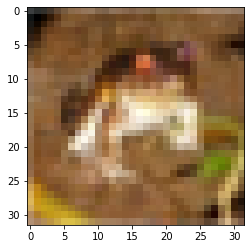

[[5.7690404e-03 3.7498358e-03 2.4631290e-01 ... 2.2994504e-04
  1.9262538e-06 1.4384363e-09]
 [1.1872522e-01 1.4284481e-01 1.4213353e-01 ... 8.7123066e-02
  1.1675209e-03 1.2633955e-03]
 [1.1872522e-01 1.4284481e-01 1.4213353e-01 ... 8.7123066e-02
  1.1675209e-03 1.2633955e-03]
 ...
 [1.1872522e-01 1.4284481e-01 1.4213353e-01 ... 8.7123066e-02
  1.1675209e-03 1.2633955e-03]
 [1.1872522e-01 1.4284481e-01 1.4213353e-01 ... 8.7123066e-02
  1.1675209e-03 1.2633955e-03]
 [1.1872522e-01 1.4284481e-01 1.4213353e-01 ... 8.7123066e-02
  1.1675209e-03 1.2633955e-03]]


In [31]:
x_mal, y_mal = synMalData(new_data, 1, class_num) 
print(x_mal.shape)
print(y_mal.shape)
print(m.x_test.shape)
s = reconstructImg(y_mal, class_num)
img = decode(s, toImg = True)[0]

plt.imshow(img)
plt.show()



In [54]:
print(x_mal.shape)
print(y_mal_p[1995:2000])

(8192, 32, 32, 3)
[[0.11872522 0.14284481 0.14213353 0.12388263 0.13107608 0.12823077
  0.12355298 0.08712307 0.00116752 0.0012634 ]
 [0.11872522 0.14284481 0.14213353 0.12388263 0.13107608 0.12823077
  0.12355298 0.08712307 0.00116752 0.0012634 ]
 [0.11872522 0.14284481 0.14213353 0.12388263 0.13107608 0.12823077
  0.12355298 0.08712307 0.00116752 0.0012634 ]
 [0.11872522 0.14284481 0.14213353 0.12388263 0.13107608 0.12823077
  0.12355298 0.08712307 0.00116752 0.0012634 ]
 [0.11872522 0.14284481 0.14213353 0.12388263 0.13107608 0.12823077
  0.12355298 0.08712307 0.00116752 0.0012634 ]]


(8192,)
[1 6 6 2 5 4 6 2 2 1]
1
(8192, 10)
[[5.7690404e-03 3.7498358e-03 2.4631290e-01 ... 2.2994504e-04
  1.9262538e-06 1.4384363e-09]
 [1.1872522e-01 1.4284481e-01 1.4213353e-01 ... 8.7123066e-02
  1.1675209e-03 1.2633955e-03]
 [1.1872522e-01 1.4284481e-01 1.4213353e-01 ... 8.7123066e-02
  1.1675209e-03 1.2633955e-03]
 ...
 [1.1872522e-01 1.4284481e-01 1.4213353e-01 ... 8.7123066e-02
  1.1675209e-03 1.2633955e-03]
 [1.1872522e-01 1.4284481e-01 1.4213353e-01 ... 8.7123066e-02
  1.1675209e-03 1.2633955e-03]
 [1.1872522e-01 1.4284481e-01 1.4213353e-01 ... 8.7123066e-02
  1.1675209e-03 1.2633955e-03]]
[0 1 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[

[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]


[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]


[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]


[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]


[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]
[0 0 1]


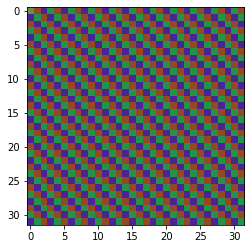

In [49]:
def reconstructImg_2(y_mal, class_num):
    # reconstruct graph
    secret = []
    for y in y_mal:
        secret.extend(np.unpackbits(np.array(np.argmax(y), np.uint8))[5:]) 
        print(np.unpackbits(np.array(np.argmax(y), np.uint8))[5:])
    return secret

print(y_mal.shape)
print(y_mal[:10])
print(y_mal[0])
print(y_mal_p.shape)
print(y_mal_p)
s = reconstructImg_2(y_mal_p, class_num)
img = decode(s, toImg = True)[0]

plt.imshow(img)
plt.show()